In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, Flatten, AveragePooling2D, Dropout,GlobalAveragePooling2D, MaxPooling2D, Flatten, BatchNormalization
from keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam

from keras import backend as K
import util

import os
from os.path import join
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)

In [ ]:
wandb.init(
    project ='BTP',
    name = 'Chexpert',
    config={
        'root_path': "E:/CogXR/datasets/chexpert_final",
        'df':"E:/CogXR/datasets/chexpert_final/chexpert_labels.csv",
        'labels' : ['No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices','COVID', 'TB'],
        'lr': 0.0001,
        'batch_size': 32,
        'epoch': 30,
        'save_file_name': 'btp',
        'target_labels': ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema','Pneumonia', 'Pleural Effusion','COVID','TB'],
    }
)

wandb: Currently logged in as: ashu1069 (cogxrlabs). Use `wandb login --relogin` to force relogin


In [ ]:
config = wandb.config
data_path = Path(config.root_path)

In [ ]:
df = pd.read_csv(config.df)
df

,Unnamed: 0.1,Unnamed: 0,Path,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,COVID,TB
0,0,0,Images/0.png,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1,1,Images/1.png,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2,2,Images/2.png,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,3,3,Images/3.png,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4,4,Images/4.png,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242452,242452,242452,Images/242452.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
242453,242453,242453,Images/242453.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
242454,242454,242454,Images/242454.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
242455,242455,242455,Images/242455.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
train_df = df.sample(frac = 0.8)
test_df = df.drop(train_df.index)

### Data Generator

In [ ]:
def get_train_and_valid_generator(df, image_dir, x_col, y_col,
                        shuffle=True, batch_size=config.batch_size, seed=1,
                        target_w = 320, target_h = 320):
    # x_col (str): name of column in df that holds filenames.
    # y_col (list): name of column in df that holds labels.

    print("getting train and val generator...")
    # normalize each image using batch statistic
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True,
        zoom_range = 0.1,
        rotation_range = 5,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        validation_split = 0.1
    )

    # Train and valid generator
    train_generator = image_generator.flow_from_dataframe(
                                dataframe=df,
                                directory=data_path,
                                x_col=x_col,
                                y_col=y_col,
                                class_mode="raw",
                                batch_size=batch_size,
                                shuffle=shuffle,
                                seed=seed,
                                subset="training",
                                target_size=(target_w,target_h))

    valid_generator = image_generator.flow_from_dataframe(
                                dataframe=df,
                                directory=data_path,
                                x_col=x_col,
                                y_col=y_col,
                                class_mode="raw",
                                batch_size=batch_size,
                                shuffle=shuffle,
                                seed=seed,
                                subset="validation",
                                target_size=(target_w,target_h))

    return train_generator, valid_generator

In [ ]:
train_generator, val_generator = get_train_and_valid_generator(df=train_df, image_dir=data_path/'Images',
                                                   x_col="Path", y_col=config.target_labels,
                                                   seed=42)

getting train and val generator...
Found 149918 validated image filenames.
Found 16657 validated image filenames.


In [ ]:
test_datagen=image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                      directory=data_path,
                                                      target_size=(320,320),
                                                      class_mode='raw',
                                                      batch_size=config.batch_size,
                                                      shuffle=True,
                                                      x_col="Path", y_col=config.target_labels, seed=42)

Found 41621 validated image filenames.


### Class Imbalance Handling

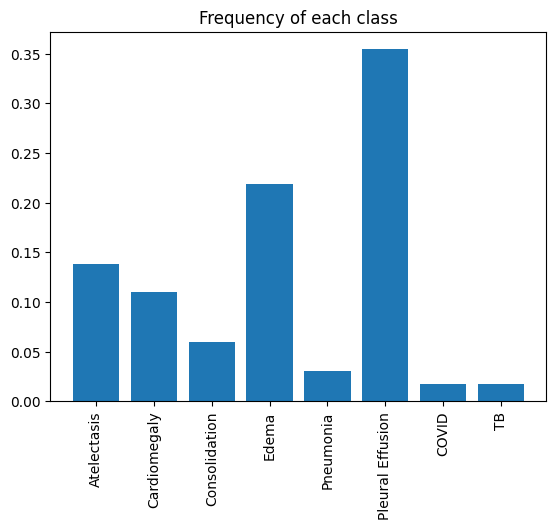

In [ ]:
plt.xticks(rotation=90)
plt.bar(x=config.target_labels, height = np.mean(train_generator.labels, axis=0))
plt.title('Frequency of each class')
plt.show()

In [ ]:
def compute_class_freq(labels):
    N = labels.shape[0]

    pos_freq = np.sum(labels, axis=0)/N
    neg_freq = 1-pos_freq

    return pos_freq, neg_freq

In [ ]:
pos_freq, neg_freq = compute_class_freq(train_generator.labels)

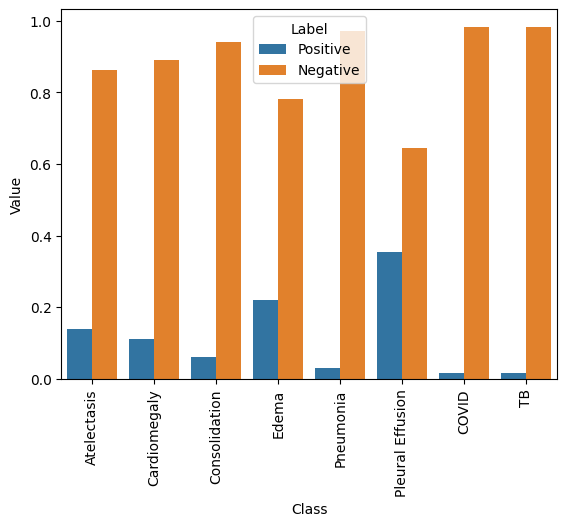

In [ ]:
data = pd.DataFrame({'Class': config.target_labels, 'Label': 'Positive', 'Value': pos_freq})
data = data.append([{'Class': config.target_labels[l], 'Label': 'Negative', 'Value': v} for l,v in enumerate(neg_freq)], ignore_index=True)

plt.xticks(rotation=90)
f = sns.barplot(x='Class', y='Value', hue='Label', data=data)

In [ ]:
pos_weights = neg_freq
neg_weights = pos_freq

pos_contri = pos_freq*pos_weights
neg_contri = neg_freq*neg_weights

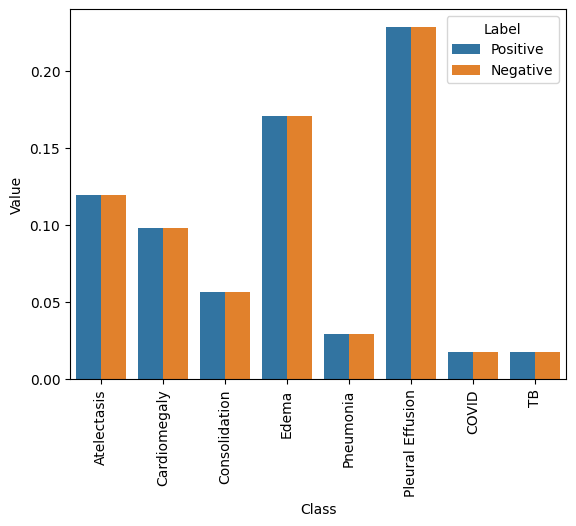

In [ ]:
data = pd.DataFrame({'Class': config.target_labels, 'Label': 'Positive', 'Value': pos_contri})
data = data.append([{'Class': config.target_labels[l], 'Label': 'Negative', 'Value': v} for l,v in enumerate(neg_contri)], ignore_index=True)

plt.xticks(rotation=90)
f = sns.barplot(x='Class', y='Value', hue='Label', data=data)

In [ ]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-3):

    def weighted_loss(y_true, y_pred):
        loss=0.0

        for i in range(len(pos_weights)):
            loss += K.mean(-(pos_weights[i]*y_true[:,i]*K.log(y_pred[:,i]+epsilon)
                             +neg_weights[i]*(1-y_true[:,i])*K.log(1-y_pred[:,i]+epsilon)))

        return loss
    return weighted_loss

In [ ]:
def build_model(image_size = 320, load_previous_weights = True):
    base_model = DenseNet121(include_top= False, input_shape=(image_size,image_size,3), weights='imagenet')

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(len(config.target_labels), activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(lr=config.lr), loss=get_weighted_loss(pos_weights, neg_weights), metrics=['accuracy','AUC'])
    return model

In [ ]:
train_x, train_y = next(train_generator)

In [ ]:
x = val_generator.n//val_generator.batch_size

In [ ]:
model = build_model(image_size=320, load_previous_weights=True)

In [ ]:
history = model.fit(train_generator, steps_per_epoch = 100, validation_data = val_generator, validation_steps = x, epochs = config.epoch)

Epoch 1/30
100/100 [==============================] - 564s 6s/step - loss: 0.7373 - accuracy: 0.3413 - auc: 0.8574 - val_loss: 0.7745 - val_accuracy: 0.4066 - val_auc: 0.8604
Epoch 2/30
100/100 [==============================] - 556s 6s/step - loss: 0.7432 - accuracy: 0.3422 - auc: 0.8601 - val_loss: 0.7319 - val_accuracy: 0.3989 - val_auc: 0.8669
Epoch 3/30
100/100 [==============================] - 557s 6s/step - loss: 0.7116 - accuracy: 0.3625 - auc: 0.8659 - val_loss: 0.7305 - val_accuracy: 0.3512 - val_auc: 0.8547
Epoch 4/30
100/100 [==============================] - 557s 6s/step - loss: 0.7326 - accuracy: 0.3713 - auc: 0.8630 - val_loss: 0.7419 - val_accuracy: 0.3660 - val_auc: 0.8847
Epoch 5/30
100/100 [==============================] - 550s 6s/step - loss: 0.7212 - accuracy: 0.3438 - auc: 0.8633 - val_loss: 0.7294 - val_accuracy: 0.3362 - val_auc: 0.8703
Epoch 6/30
100/100 [==============================] - 554s 6s/step - loss: 0.7276 - accuracy: 0.3494 - auc: 0.8645 - val_loss

In [ ]:
pred_vals = model.predict(test_generator, steps=len(test_generator))

1301/1301 [==============================] - 1170s 898ms/step


In [ ]:
# auc_rocs = util.get_roc_curve(config.target_labels, pred_vals, test_generator)

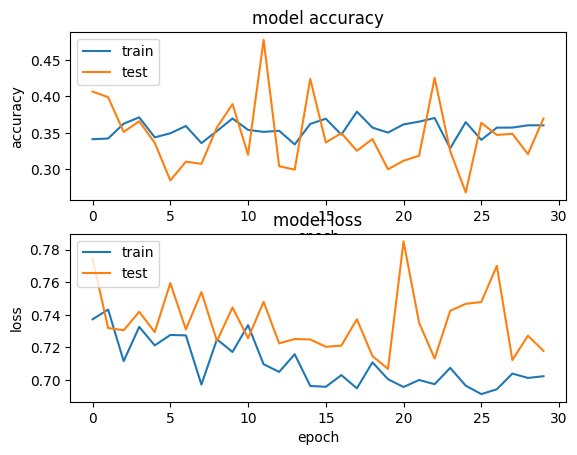

In [ ]:
plt.figure(1)
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save('chexpert_UIgnore_8.pb')

INFO:tensorflow:Assets written to: chexpert_UIgnore_8.pb\assets


INFO:tensorflow:Assets written to: chexpert_UIgnore_8.pb\assets


In [ ]:
tf.saved_model.save(model,"")

INFO:tensorflow:Assets written to: assets


INFO:tensorflow:Assets written to: assets


In [ ]:
test_generator.labels[2]

In [ ]:
predictions = np.argmax(pred_vals[2])

In [ ]:
%pwd

'C:\\Users\\User1\\chexpert'

In [ ]:
import tensorflow as tf
imported = tf.saved_model.load("")

In [ ]:
print(list(imported.signatures.keys()))

['serving_default']


In [ ]:
infer = imported.signatures["serving_default"]
print(infer.structured_outputs)

{'dense': TensorSpec(shape=(None, 8), dtype=tf.float32, name='dense')}


In [ ]:
print(infer.inputs)

[<tf.Tensor 'input_1:0' shape=(None, 320, 320, 3) dtype=float32>, <tf.Tensor 'unknown:0' shape=() dtype=resource>, <tf.Tensor 'unknown_0:0' shape=() dtype=resource>, <tf.Tensor 'unknown_1:0' shape=() dtype=resource>, <tf.Tensor 'unknown_2:0' shape=() dtype=resource>, <tf.Tensor 'unknown_3:0' shape=() dtype=resource>, <tf.Tensor 'unknown_4:0' shape=() dtype=resource>, <tf.Tensor 'unknown_5:0' shape=() dtype=resource>, <tf.Tensor 'unknown_6:0' shape=() dtype=resource>, <tf.Tensor 'unknown_7:0' shape=() dtype=resource>, <tf.Tensor 'unknown_8:0' shape=() dtype=resource>, <tf.Tensor 'unknown_9:0' shape=() dtype=resource>, <tf.Tensor 'unknown_10:0' shape=() dtype=resource>, <tf.Tensor 'unknown_11:0' shape=() dtype=resource>, <tf.Tensor 'unknown_12:0' shape=() dtype=resource>, <tf.Tensor 'unknown_13:0' shape=() dtype=resource>, <tf.Tensor 'unknown_14:0' shape=() dtype=resource>, <tf.Tensor 'unknown_15:0' shape=() dtype=resource>, <tf.Tensor 'unknown_16:0' shape=() dtype=resource>, <tf.Tensor 

In [ ]:
# from PIL import Image
# img = Image.open("100.jpg")
# newsize=(320,320)
# img = img.resize(newsize)
# img_to_tensor = tf.convert_to_tensor(img)
# print(img_to_tensor)
# print("dtype of tensor:",img_to_tensor.dtype)

In [ ]:
img = tf.io.read_file("100.png")

# convert to tensor (specify 3 channels explicitly since png files contains additional alpha channel)
# set the dtypes to align with pytorch for comparison since it will use uint8 by default
tensor = tf.io.decode_image(img, channels=3, dtype=tf.dtypes.float32)
# (384, 470, 3)

# resize tensor to 224 x 224
tensor = tf.image.resize(tensor, [320, 320])
# (224, 224, 3)

# add another dimension at the front to get NHWC shape
input_tensor = tf.expand_dims(tensor, axis=0)

In [ ]:
input_tensor

<tf.Tensor: shape=(1, 320, 320, 3), dtype=float32, numpy=
array([[[[0.58523285, 0.58523285, 0.58523285],
         [0.58504903, 0.58504903, 0.58504903],
         [0.5398285 , 0.5398285 , 0.5398285 ],
         ...,
         [0.02830883, 0.02830883, 0.02830883],
         [0.07941177, 0.07941177, 0.07941177],
         [0.23149511, 0.23149511, 0.23149511]],

        [[0.29779413, 0.29779413, 0.29779413],
         [0.33933824, 0.33933824, 0.33933824],
         [0.3394608 , 0.3394608 , 0.3394608 ],
         ...,
         [0.02591912, 0.02591912, 0.02591912],
         [0.06648285, 0.06648285, 0.06648285],
         [0.21942404, 0.21942404, 0.21942404]],

        [[0.19037992, 0.19037992, 0.19037992],
         [0.20373777, 0.20373777, 0.20373777],
         [0.15091912, 0.15091912, 0.15091912],
         ...,
         [0.02199755, 0.02199755, 0.02199755],
         [0.05055147, 0.05055147, 0.05055147],
         [0.1998162 , 0.1998162 , 0.1998162 ]],

        ...,

        [[0.01930147, 0.01930147, 